In [2]:
%matplotlib inline
import matplotlib
import os
import pandas as pd
import louvain
import igraph as ig

import collections
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from nwtools import communities

In [3]:
edges_dict = {}
datapath = '/media/sf_VBox_Shared/networks/trade/import/'
for year in range(1995, 2013):
    edges_dict[str(year)] = pd.read_csv(os.path.join(datapath, 'import-links-{}.csv'.format(year))
                                       , keep_default_na=False)

In [4]:
nodes = pd.read_csv('/media/sf_VBox_Shared/networks/trade/countries.csv', keep_default_na=False,  
                    index_col='Id')

In [5]:
for year in edges_dict:
    edges_dict[year]['Distance'] = 1.0 / edges_dict[year]['Weight']

In [6]:
def igraph_from_edgelist(edges, source='Source', target='Target', attributes=None):
    g = ig.Graph()

    node_names = list(set(edges[source]).union(set(edges[target])))

    g.add_vertices(node_names)

    g.add_edges([(s, t) for s, t in edges[[source, target]].values])
    
    if attributes is None:
        attributes = ['Weight']
    for att in attributes:
        g.es[att.lower()] = list(edges[att])
        
    return g

In [7]:
graphs = {year: igraph_from_edgelist(edges_dict[year], attributes=['Weight', 'Distance']) for year in edges_dict}

Iteration 0
Smallest connected component: 186


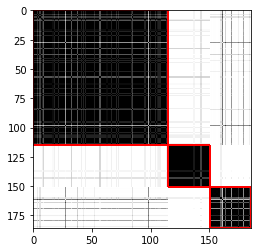

Iteration 1
Smallest connected component: 36


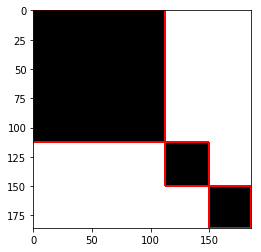

Converged!
Iteration 0
Smallest connected component: 15


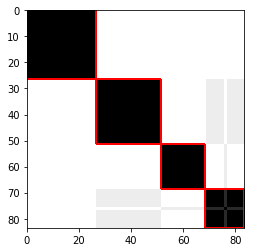

Iteration 1
Smallest connected component: 15


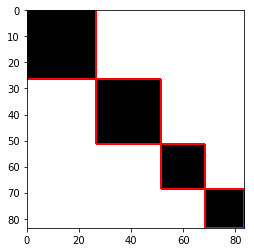

Converged!
Iteration 0
Smallest connected component: 184


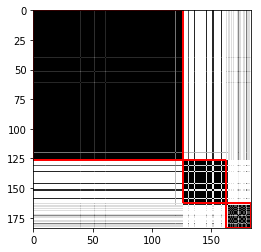

Iteration 1
Smallest connected component: 20


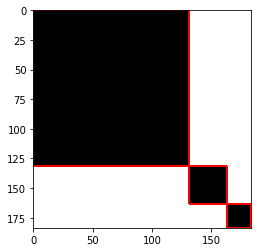

Converged!
Iteration 0
Smallest connected component: 186


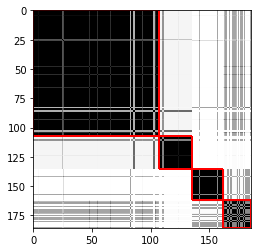

Iteration 1
Smallest connected component: 31


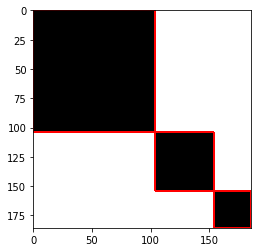

Converged!
Iteration 0
Smallest connected component: 186


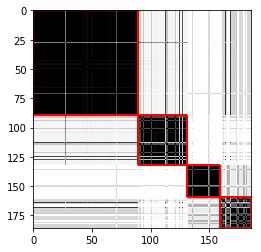

Iteration 1
Smallest connected component: 40


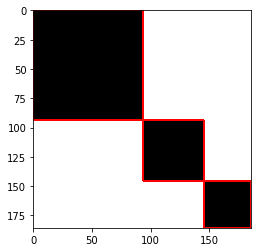

Converged!
Iteration 0
Smallest connected component: 27


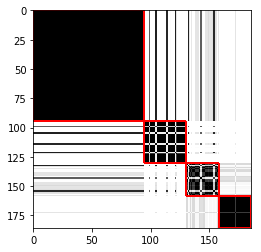

Iteration 1
Smallest connected component: 25


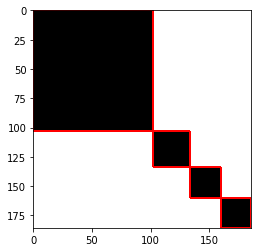

Converged!
Iteration 0
Smallest connected component: 51


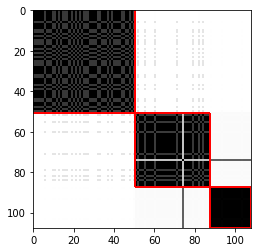

Iteration 1
Smallest connected component: 21


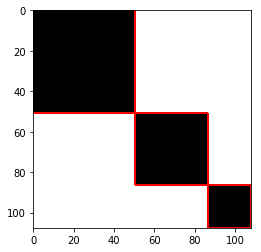

Converged!
Iteration 0
Smallest connected component: 186


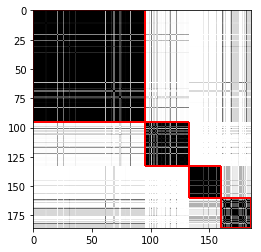

Iteration 1
Smallest connected component: 39


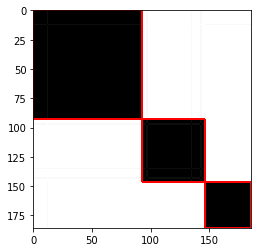

Iteration 2
Smallest connected component: 39


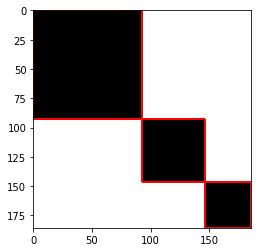

Converged!
Iteration 0
Smallest connected component: 186


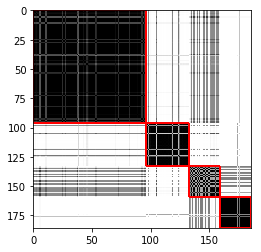

Iteration 1
Smallest connected component: 15


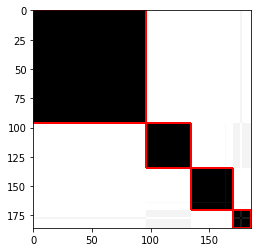

Iteration 2
Smallest connected component: 15


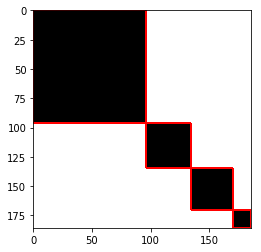

Converged!
Iteration 0
Smallest connected component: 89


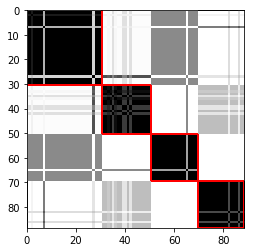

Iteration 1
Smallest connected component: 43


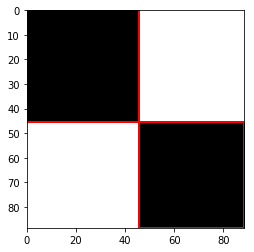

Converged!
Iteration 0
Smallest connected component: 12


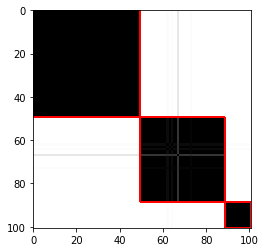

Iteration 1
Smallest connected component: 12


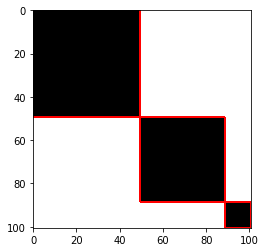

Converged!
Iteration 0
Smallest connected component: 89


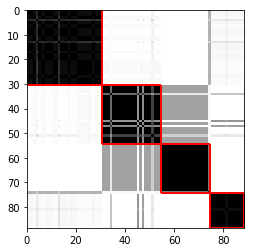

Iteration 1
Smallest connected component: 14


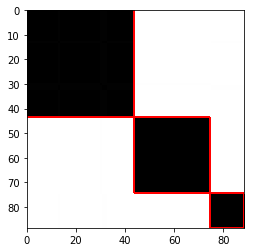

Iteration 2
Smallest connected component: 14


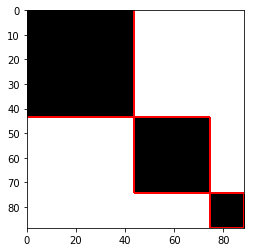

Converged!
Iteration 0
Smallest connected component: 34


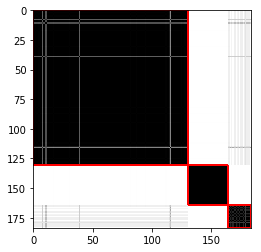

Iteration 1
Smallest connected component: 20


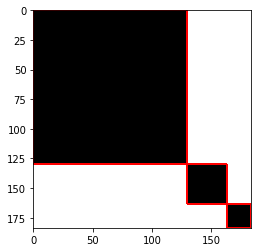

Converged!
Iteration 0
Smallest connected component: 89


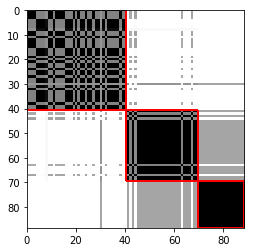

Iteration 1
Smallest connected component: 41


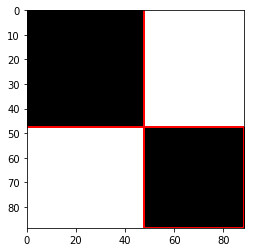

Converged!
Iteration 0
Smallest connected component: 30


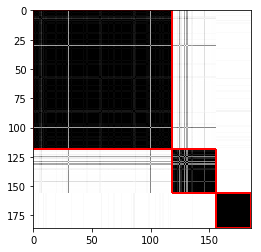

Iteration 1
Smallest connected component: 30


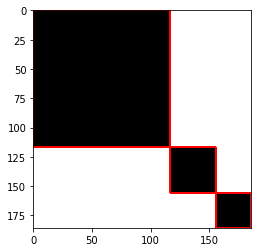

Converged!
Iteration 0
Smallest connected component: 27


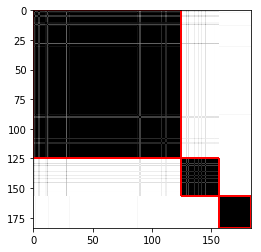

Iteration 1
Smallest connected component: 27


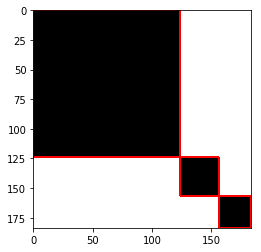

Converged!
Iteration 0
Smallest connected component: 27


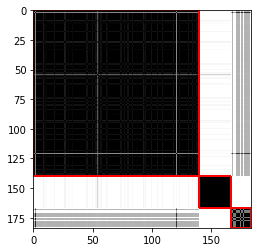

Iteration 1
Smallest connected component: 19


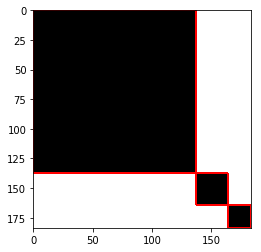

Converged!
Iteration 0
Smallest connected component: 10


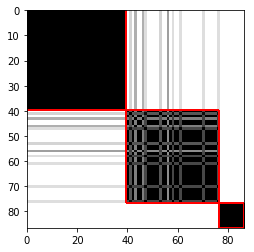

Iteration 1
Smallest connected component: 10


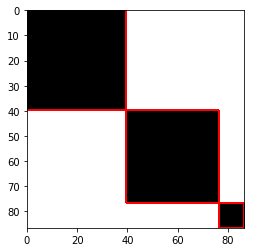

Converged!


In [8]:
consensus_matrices_dict = {}
partition_dict = {}
for year in graphs:
    cons, part = communities.consensus_partition(graphs[year], verbose=True, threshold=0.3, 
                                     nr_partitions=100, weights='weight')
    consensus_matrices_dict[year] = cons
    partition_dict[year] = part

In [9]:
# Filter out single communities 
partition_filtered_dict = {}
from collections import Counter
for year in graphs:
    part_sizes = Counter(partition_dict[year])
    partition_filtered_dict[year] = [p if part_sizes[p] > 1 else np.nan for p in partition_dict[year]]

In [10]:
nodes_merged = nodes.copy()

for year in partition_dict:
    consensus_s = pd.Series(partition_filtered_dict[year], index=graphs[year].vs['name'])
    nodes_merged['consensus_{}'.format(year)] = consensus_s
    
nodes_merged = nodes_merged.dropna(subset=['consensus_{}'.format(y) for y in graphs], how='all')

In [11]:
consensus_columns = ['consensus_{}'.format(year) for year in graphs]

In [12]:
def add_statistics(graph, nodes, suffix):
    names = graph.vs.get_attribute_values('name')
    
    nodes['degree_'+suffix] = pd.Series(graph.degree(), index=names)
    nodes['weighted_degree_'+suffix] = pd.Series(graph.strength(weights='weight'), index=names)
    nodes['eigenvector_centrality_'+suffix] = pd.Series(
        graph.eigenvector_centrality(directed=False, weights='weight'), index=names)
    nodes['betweenness_'+suffix] = pd.Series(graph.betweenness(directed=False, weights='distance'), index=names)

In [13]:
for year in graphs.keys():
    add_statistics(graphs[year], nodes_merged, year)

In [14]:
nodes_merged.head()

,Label,latitude,longitude,name,consensus_2007,consensus_2006,consensus_1995,consensus_2003,consensus_2010,consensus_2008,...,eigenvector_centrality_2005,betweenness_2005,degree_2004,weighted_degree_2004,eigenvector_centrality_2004,betweenness_2004,degree_1999,weighted_degree_1999,eigenvector_centrality_1999,betweenness_1999
Id,,,,,,,,,,,,,,,,,,,,,
AE,United Arab Emirates,23.424076,53.847818,United Arab Emirates,0.0,0.0,3.0,2.0,0.0,0.0,...,0.009368,0.0,25.0,3341.4812,0.006485,0.0,2.0,459.3070,0.001963,0.0
AF,Afghanistan,33.93911,67.709953,Afghanistan,2.0,2.0,NaN,1.0,0.0,1.0,...,0.000128,0.0,20.0,52.7047,0.000133,0.0,NaN,NaN,NaN,NaN
AG,Antigua and Barbuda,17.060816,-61.796428,Antigua and Barbuda,1.0,1.0,NaN,1.0,0.0,2.0,...,0.000576,0.0,19.0,192.7468,0.000737,0.0,NaN,NaN,NaN,NaN
AI,Anguilla,18.220554,-63.068615,Anguilla,1.0,2.0,NaN,1.0,1.0,1.0,...,0.000017,0.0,16.0,6.0209,0.000018,0.0,NaN,NaN,NaN,NaN
AL,Albania,41.153332,20.168331,Albania,1.0,1.0,2.0,1.0,1.0,1.0,...,0.000389,0.0,21.0,574.0981,0.000588,0.0,5.0,14.9244,0.000056,0.0


In [15]:
nodes_merged.sort_values('weighted_degree_2008', ascending=False).head()

,Label,latitude,longitude,name,consensus_2007,consensus_2006,consensus_1995,consensus_2003,consensus_2010,consensus_2008,...,eigenvector_centrality_2005,betweenness_2005,degree_2004,weighted_degree_2004,eigenvector_centrality_2004,betweenness_2004,degree_1999,weighted_degree_1999,eigenvector_centrality_1999,betweenness_1999
Id,,,,,,,,,,,,,,,,,,,,,
US,United States,37.09024,-95.712891,United States,0.0,0.0,1.0,0.0,0.0,0.0,...,1.000000,7511.0,68.0,481453.3290,1.000000,6971.0,57.0,343125.6112,1.000000,2948.0
GB,United Kingdom,55.378051,-3.435973,United Kingdom,1.0,1.0,1.0,1.0,0.0,0.0,...,0.783750,8011.0,215.0,335721.3924,0.799032,8527.0,74.0,170344.5533,0.668106,846.0
DE,Germany,51.165691,10.451526,Germany,1.0,1.0,2.0,1.0,1.0,1.0,...,0.610576,3884.0,59.0,273809.3918,0.617455,3023.0,36.0,153454.5376,0.509360,1345.0
FR,France,46.227638,2.213749,France,1.0,1.0,3.0,1.0,1.0,1.0,...,0.443473,5561.0,214.0,195004.9290,0.459824,6770.0,29.0,63328.6461,0.317826,320.0
JP,Japan,36.204824,138.252924,Japan,0.0,0.0,1.0,0.0,0.0,0.0,...,0.503486,722.0,66.0,165807.6439,0.493292,1075.0,55.0,122308.5045,0.554238,652.0


In [16]:
from scipy.optimize import linear_sum_assignment

In [17]:
def get_mapping(ctab):
    if ctab.shape[0] > ctab.shape[1]:
        raise Exception('Rows should be fewer than columns')
        
    # Use the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(- ctab.values)
    mapXtoY = {ctab.index[r]: ctab.columns[c] for r, c in zip(row_ind, col_ind)}
    return(mapXtoY)

In [18]:
# Which graph has the largest number of communities?
maxyear = nodes_merged[consensus_columns].nunique(axis=0).idxmax()[-4:]
print('Year with most communities: {}'.format(maxyear))
for year in graphs:
    if year == maxyear:
        nodes_merged['consensus_mapped_{}'.format(year)] = nodes_merged['consensus_{}'.format(year)]
    else:
        ctab = pd.crosstab(index=nodes_merged['consensus_{}'.format(year)], 
                           columns=nodes_merged['consensus_{}'.format(maxyear)])
        m = get_mapping(ctab)
        nodes_merged['consensus_mapped_{}'.format(year)] = [m.get(c, c) for c in 
                                                            nodes_merged['consensus_{}'.format(year)]]

Year with most communities: 1995


In [19]:
consensus_mapped_columns = ['consensus_mapped_{}'.format(year) for year in graphs]

In [20]:
nodes_merged.head()

,Label,latitude,longitude,name,consensus_2007,consensus_2006,consensus_1995,consensus_2003,consensus_2010,consensus_2008,...,consensus_mapped_2012,consensus_mapped_1996,consensus_mapped_2001,consensus_mapped_1998,consensus_mapped_2002,consensus_mapped_1997,consensus_mapped_2006,consensus_mapped_2005,consensus_mapped_2004,consensus_mapped_1999
Id,,,,,,,,,,,,,,,,,,,,,
AE,United Arab Emirates,23.424076,53.847818,United Arab Emirates,0.0,0.0,3.0,2.0,0.0,0.0,...,3.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0
AF,Afghanistan,33.93911,67.709953,Afghanistan,2.0,2.0,NaN,1.0,0.0,1.0,...,1.0,NaN,NaN,NaN,2.0,NaN,2.0,1.0,1.0,NaN
AG,Antigua and Barbuda,17.060816,-61.796428,Antigua and Barbuda,1.0,1.0,NaN,1.0,0.0,2.0,...,3.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN
AI,Anguilla,18.220554,-63.068615,Anguilla,1.0,2.0,NaN,1.0,1.0,1.0,...,2.0,NaN,NaN,NaN,1.0,NaN,2.0,1.0,1.0,NaN
AL,Albania,41.153332,20.168331,Albania,1.0,1.0,2.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0


In [21]:
nodes_merged['longitude'] = nodes_merged['longitude'].astype(float)
nodes_merged['latitude'] = nodes_merged['latitude'].astype(float)

In [22]:
from IPython.display import display
# Insight in each of the communities
max_community = nodes_merged[consensus_mapped_columns].fillna(-1).values.max()

for comm in range(0, int(max_community)+1):
    print('Community {}'.format(comm))
    for year in graphs:
        com_att = 'consensus_mapped_{}'.format(year)
        
        nodes_sub = nodes_merged[nodes_merged[com_att]==comm].sort_values('weighted_degree_{}'.format(year), 
                                                                      ascending=False)
        print(year, nodes_sub['name'].head(7).values)
    print('\n')

Community 0
2007 ['United States' 'Japan' 'Canada' 'South Korea' 'Hong Kong' 'Singapore'
 'China']
1995 ['Australia' 'New Zealand' 'Singapore' 'Hong Kong' 'South Korea' 'Thailand'
 'Indonesia']
2003 ['United States' 'Japan' 'Canada' 'Hong Kong' 'Singapore' 'South Korea'
 'Australia']
2010 ['United States' 'United Kingdom' 'Japan' 'China' 'Ireland' 'Hong Kong'
 'Canada']
2008 ['United States' 'United Kingdom' 'Japan' 'China' 'Ireland' 'Hong Kong'
 'Canada']
2011 ['China' 'Japan' 'Hong Kong' 'Singapore' 'South Korea' 'Australia' 'Taiwan']
2000 []
2009 ['United States' 'United Kingdom' 'Japan' 'China' 'Ireland' 'Hong Kong'
 'Canada']
2012 ['United States' 'China' 'Japan' 'Hong Kong' 'Singapore' 'Canada'
 'Australia']
1996 []
2001 []
1998 []
2002 ['United States' 'Japan' 'Canada' 'Hong Kong' 'Singapore' 'South Korea'
 'Australia']
1997 []
2006 ['United States' 'Japan' 'Canada' 'South Korea' 'Hong Kong' 'Singapore'
 'China']
2005 ['United States' 'Japan' 'Canada' 'South Korea' 'Hong Kong' '

In [23]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [24]:
def plot_communities(nodes, community_col, ax, ncom=None, size=None):
    m = Basemap(projection='cyl',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
    m.drawcoastlines(ax=ax, color='grey')
    m.drawcountries(ax=ax, color='grey')

    # Draw the country points
    minsize, maxsize = 30, 160
    if size is None:
        s = (minsize + maxsize)/2
    else:
        s = minsize + np.array(size)*(maxsize-minsize) / (max(size)-min(size))
    if ncom is None:
        ncom = nodes[community_col].nunique()
    #cmap = discrete_cmap(ncom, 'rainbow')
    cmap = plt.cm.get_cmap('tab20')
    norm = matplotlib.colors.BoundaryNorm(np.arange(0, ncom+1), ncom)
    
    for c in sorted(nodes[community_col].unique()):
        nodes_sub = nodes[nodes[community_col]==c]
        x, y = m(nodes_sub['longitude'].values, nodes_sub['latitude'].values)
        color = cmap(c/ncom) if not np.isnan(c) else 'grey'
        p = m.scatter(x,y,c=color, ax=ax, norm=norm, s=s, label=c)
    ax.legend()
    return m

/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


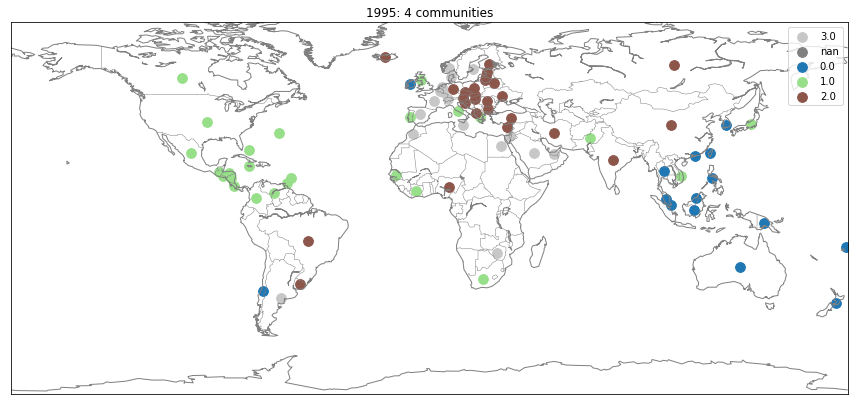

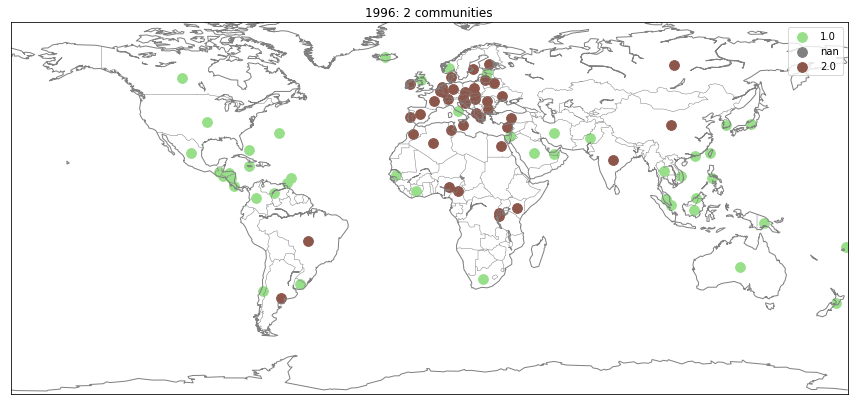

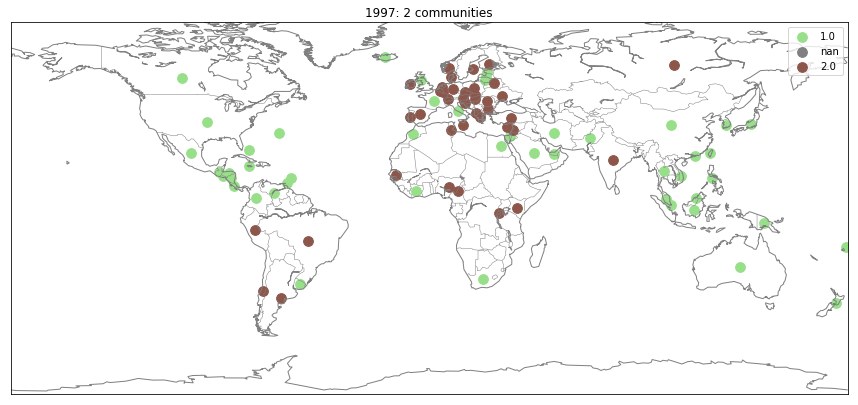

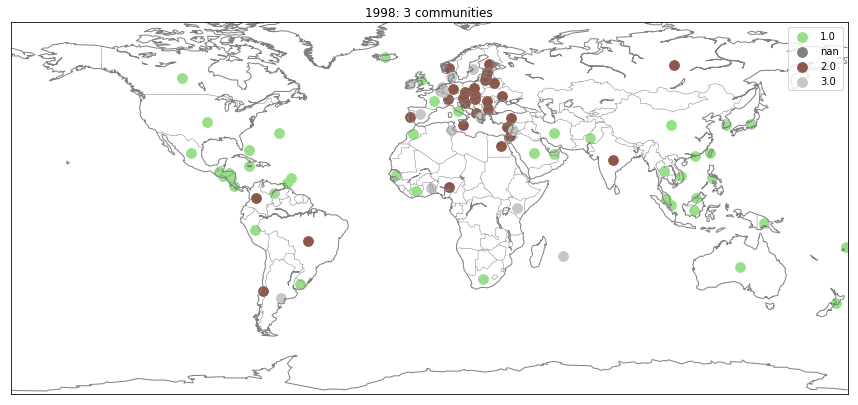

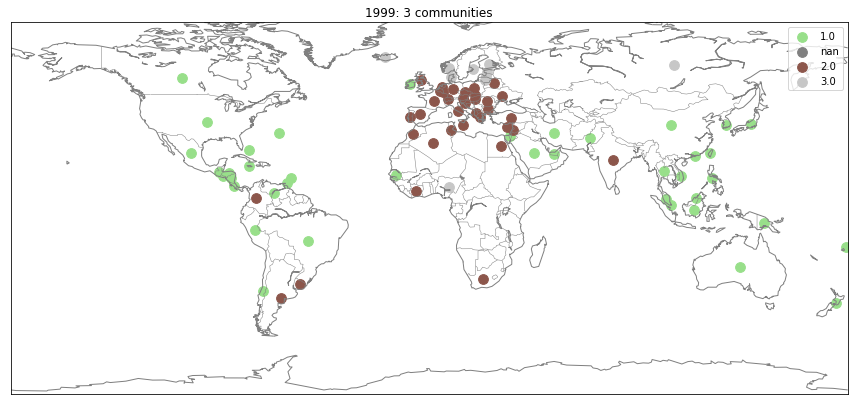

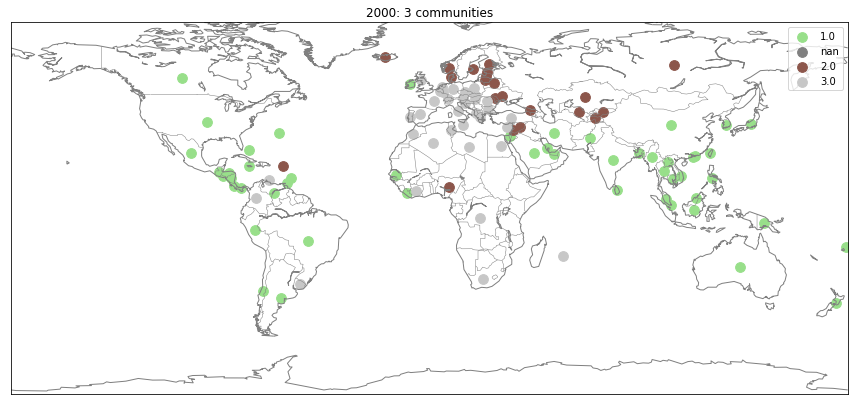

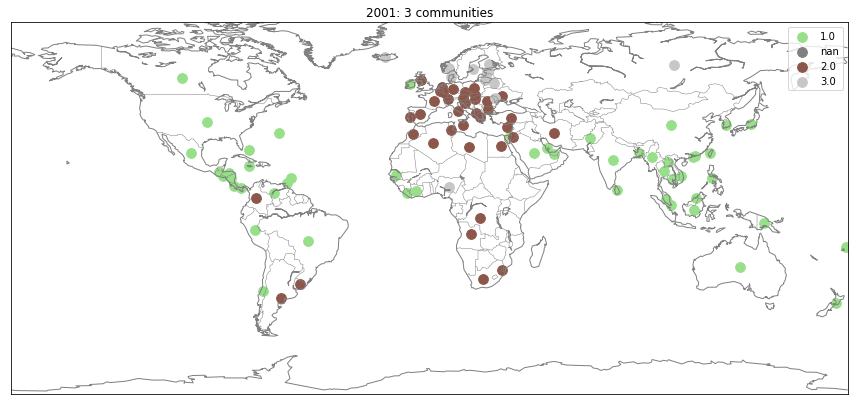

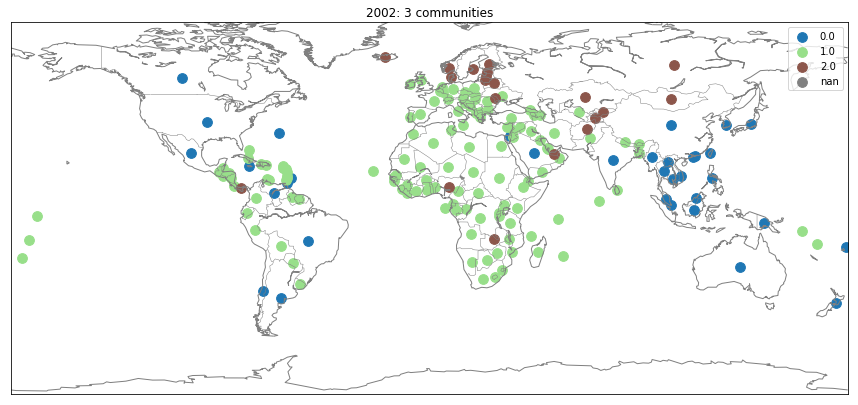

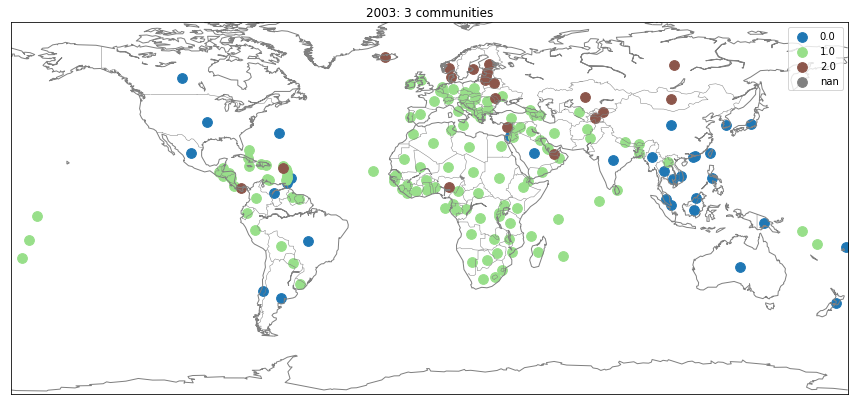

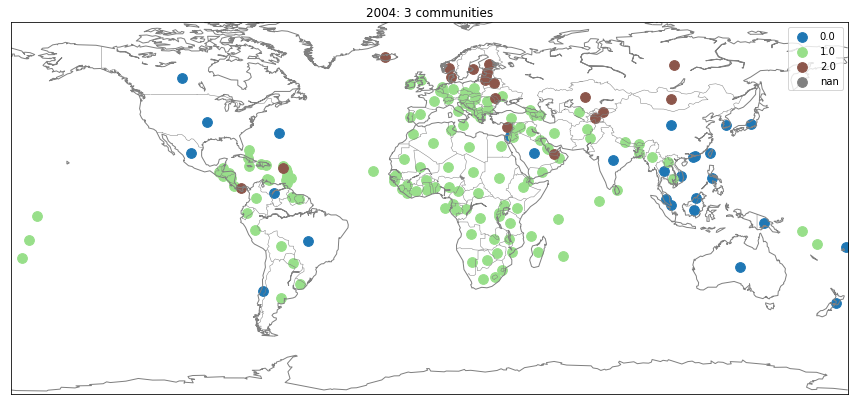

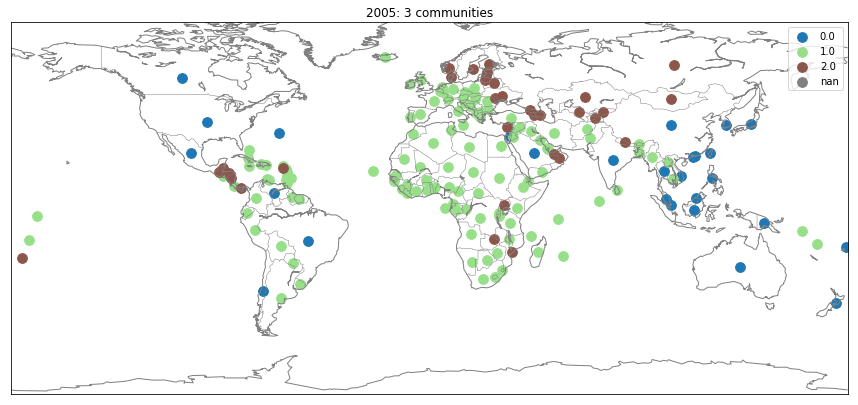

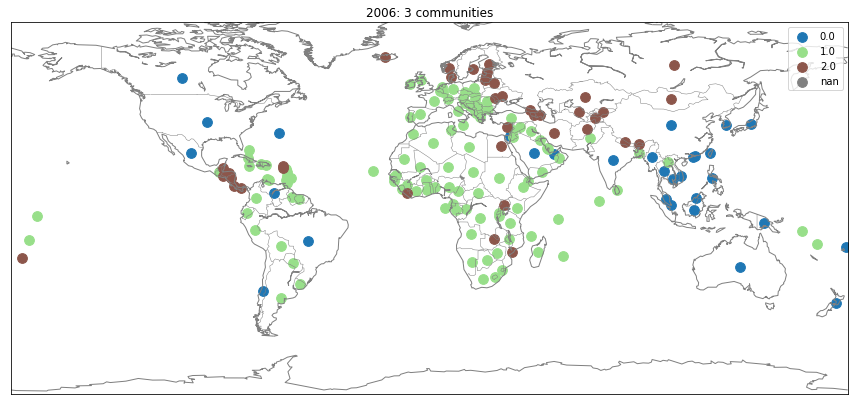

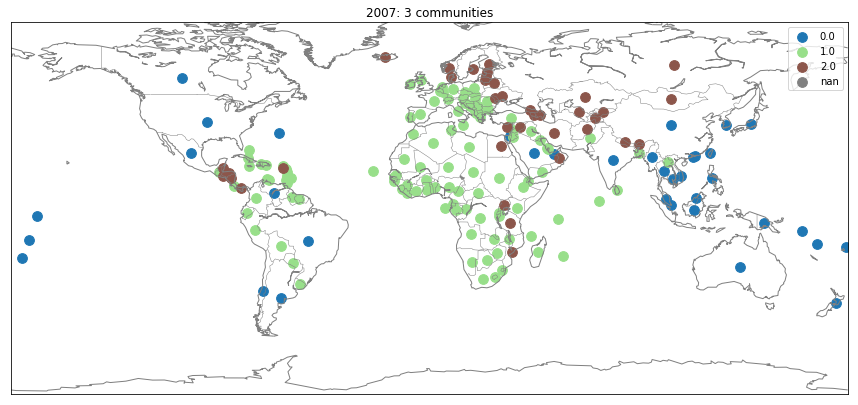

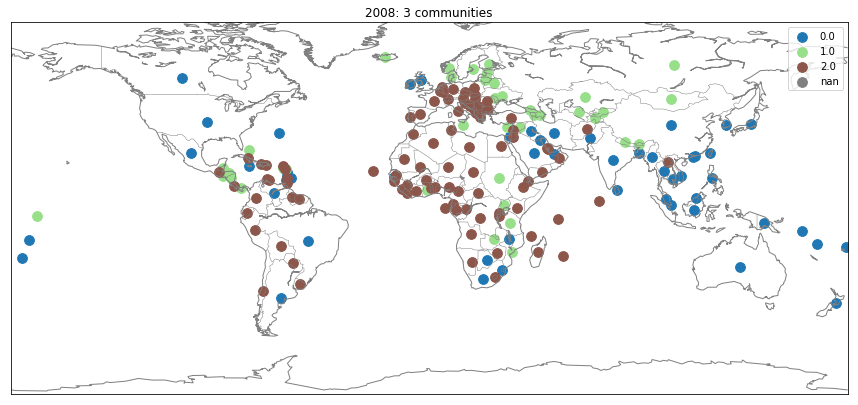

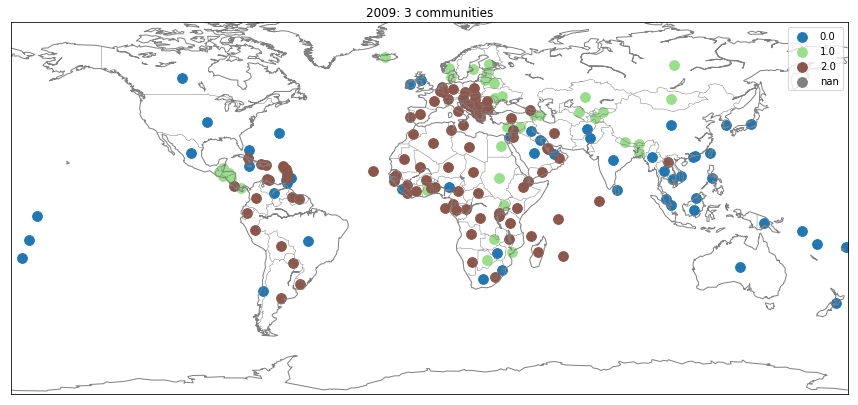

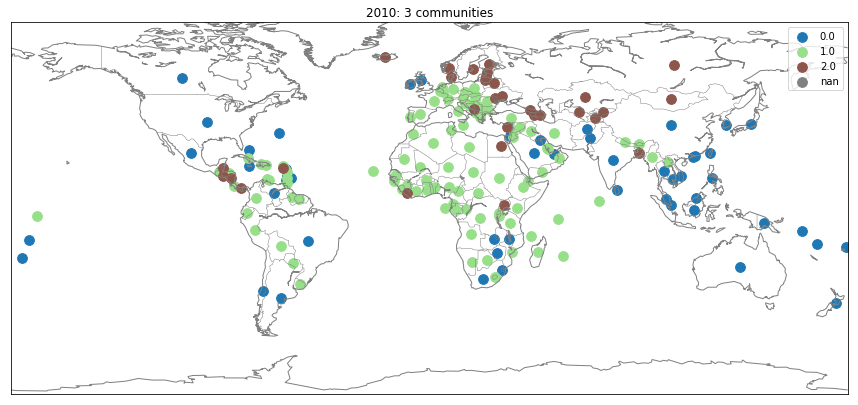

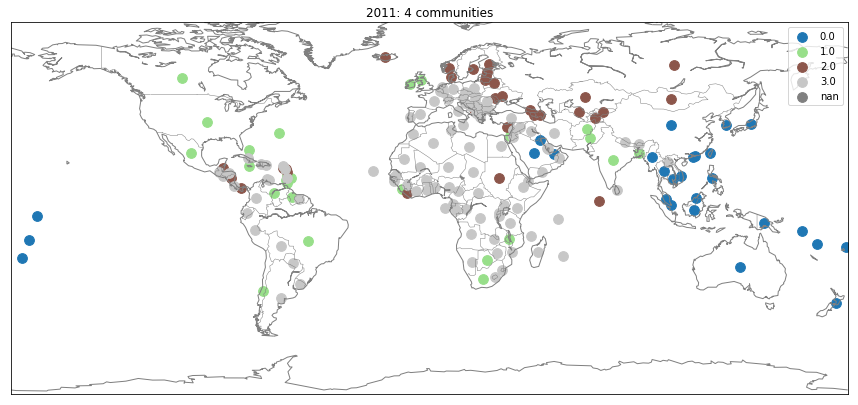

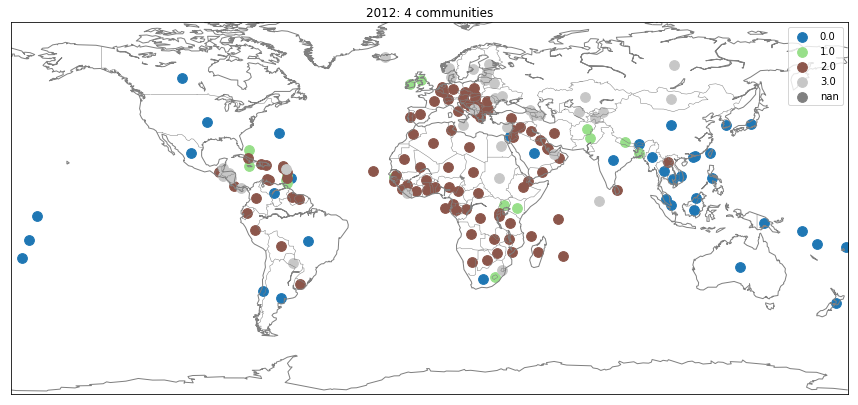

In [25]:
nr_plots = len(graphs)
ncom = nodes_merged[consensus_columns].max().max() + 1
for i, year in enumerate(sorted(graphs)):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.gca()
    if i<nr_plots:
        att = 'consensus_mapped_{}'.format(year)
        n = nodes_merged[att].nunique()
        m = plot_communities(nodes_merged, att, ax, ncom=ncom)
        ax.set_title('{}: {} communities'.format(year, n))
        plt.show()